In [2]:
# based on ryan's example (Untitled1.ipynb) and etav example (https://etav.github.io/python/scikit_pca.html)
import numpy as np
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pdspy.modeling as modeling
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation
import os
import pickle

%matplotlib inline

### read in grid data

In [3]:
# parameter value lists
T_star = []
logL_star = []
logM_disk = []
logR_disk = []
h_0 = []
logR_in = []
gamma = []
beta = []
logM_env = []
logR_env = []
f_cav = []
ksi = []
loga_max = []
p = []
incl = []

params = [T_star,logL_star,logM_disk,logR_disk,h_0,logR_in,\
          gamma,beta,logM_env,logR_env,f_cav,ksi,loga_max,p,incl]

for i in range(len(params)):
    filename="../grid_metadata/param"+str(i)+".txt"
    with open (filename, 'rb') as fp:
        params[i] = pickle.load(fp) 

# sets - filenames
with open ('../grid_metadata/core24.txt', 'rb') as fp:
    core24 = pickle.load(fp)
with open ('../grid_metadata/core78.txt', 'rb') as fp:
    core78 = pickle.load(fp)
with open ('../grid_metadata/core518.txt', 'rb') as fp:
    core518 = pickle.load(fp)
with open ('../grid_metadata/core1208.txt', 'rb') as fp:
    core1208 = pickle.load(fp)
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    corefull = pickle.load(fp)

cores=[core24,core78,core518,core1208,corefull]

    
# sets - flux values in log space
with open ('../grid_metadata/cube24.txt', 'rb') as fp:
    cube24 = np.array(pickle.load(fp))
with open ('../grid_metadata/cube78.txt', 'rb') as fp:
    cube78 = np.array(pickle.load(fp))
with open ('../grid_metadata/cube518.txt', 'rb') as fp:
    cube518 = np.array(pickle.load(fp))
with open ('../grid_metadata/cube1208.txt', 'rb') as fp:
    cube1208 = np.array(pickle.load(fp)) 
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cubefull = np.array(pickle.load(fp))

cubes=[cube24,cube78,cube518,cube1208,cubefull]

sizes=[]
for i in range(len(cores)):
    sizes.append(len(cores[i]))
    
sets=np.linspace(0.,1.,len(cores))
colors= plt.cm.viridis(sets)
    
# x values (wavelengths) - same 500 values for all sets, normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)   

### deal with -infs from log transform

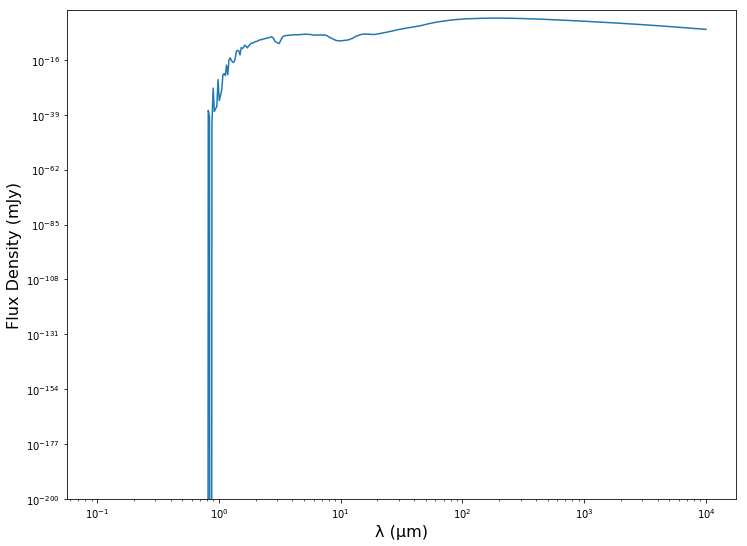

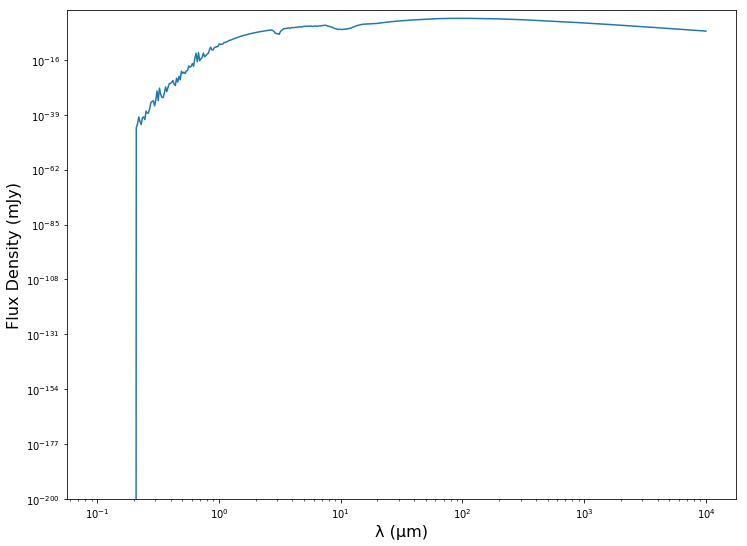

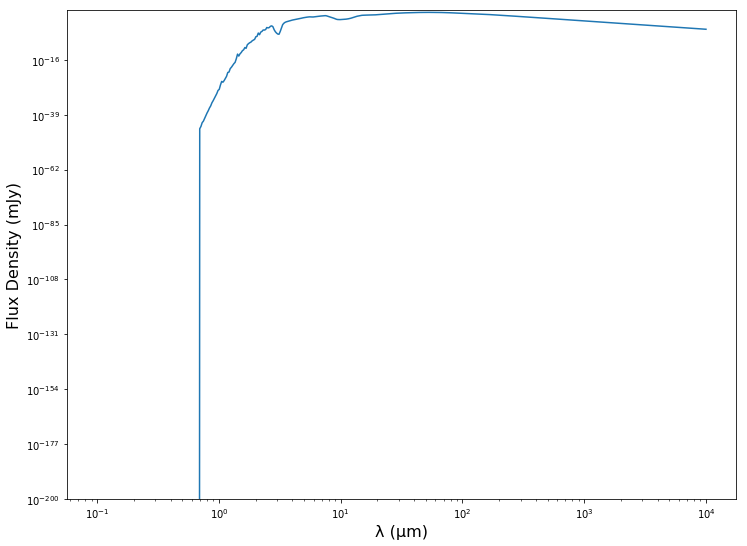

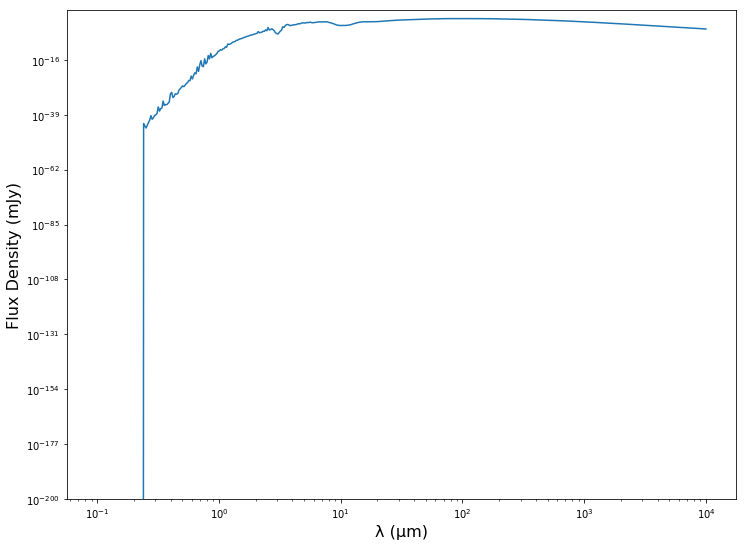

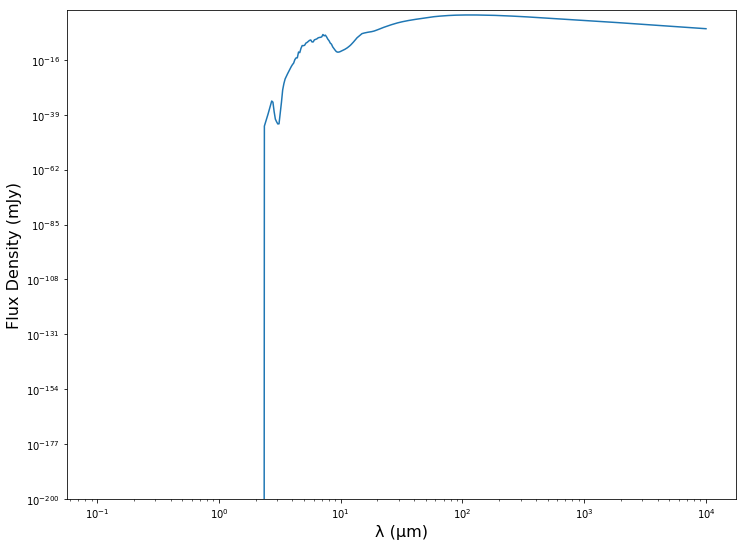

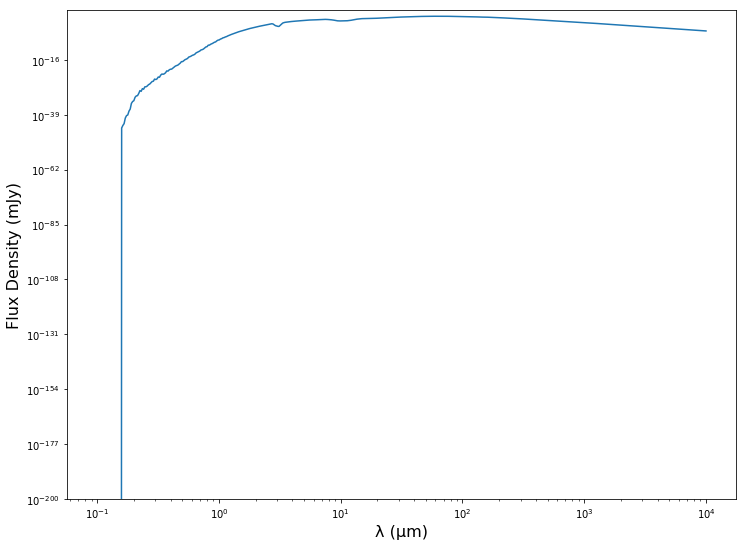

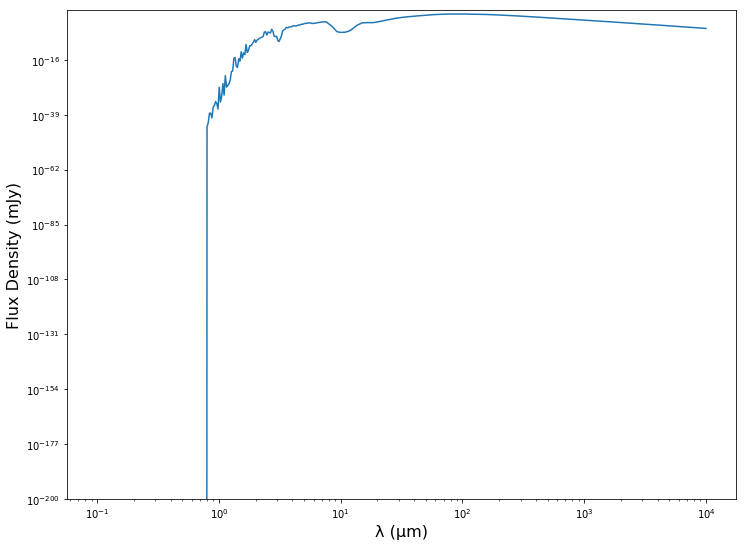

In [4]:
# check out -infs

for i in range(100):
    if -np.inf in cubes[2][i]:
        fig,ax=plt.subplots(1,figsize=(12,9))
        ax.loglog(xvals, 10**cubes[2][i])
        ax.set_ylim(1.0e-200,1.0e5)
        plt.ylabel("Flux Density (mJy)",fontsize=16)
        plt.xlabel("λ (μm)",fontsize=16)
        plt.show()

In [4]:
# horizontal cutoff below -20 to kill -infs (maybe add in a powerlaw here)
for i in range(len(cubes)):
    cubes[i][cubes[i]<-20]=-20

In [5]:
#df.replace(-np.inf,np.nan)
#cube=df

### normalizing data

In [6]:
# subtracting from the seds each sample mean
seds_msub24=[]
seds_msub78=[]
seds_msub518=[]
seds_msub1208=[]
seds_msubfull=[]

seds_msubs=[seds_msub24,seds_msub78,seds_msub518,seds_msub1208,seds_msubfull]


for i in range(len(cubes)):
    seds_msubs[i] = cubes[i] - np.mean(cubes[i],axis=1)[:,np.newaxis]

### run PCA on mean-subtracted SEDs

In [7]:
pca24=[]
pca78=[]
pca518=[]
pca1208=[]
pcafull=[]

pcas=[pca24,pca78,pca518,pca1208,pcafull]

t0 = time()
pcas[0] = PCA(n_components=24).fit(seds_msubs[0])
for i in (1,2,3,4):
    pcas[i] = PCA(n_components=40).fit(seds_msubs[i])
print("done in %0.3fs" % (time() - t0))

done in 0.100s


In [8]:
eigenseds24=[]
eigenseds78=[]
eigenseds518=[]
eigenseds1208=[]
eigensedsfull=[]


eigenseds=[eigenseds24, eigenseds78, eigenseds518, eigenseds1208, eigensedsfull]

for i in range(len(cubes)):
    eigenseds[i]=pcas[i].components_
    eigenseds=np.array(eigenseds)

### look at eigenSEDs

In [9]:
def show_SED(fluxvals):
    fig,ax=plt.subplots(1,figsize=(12,9))
    ax.plot(np.log10(xvals), fluxvals)
    #ax.set_ylim(-6,5)
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

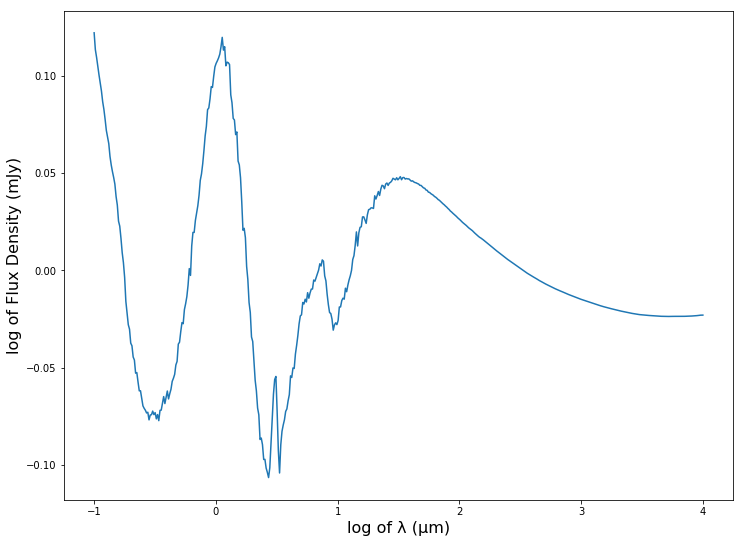

In [10]:
show_SED(eigenseds[2][4])

### variance explained

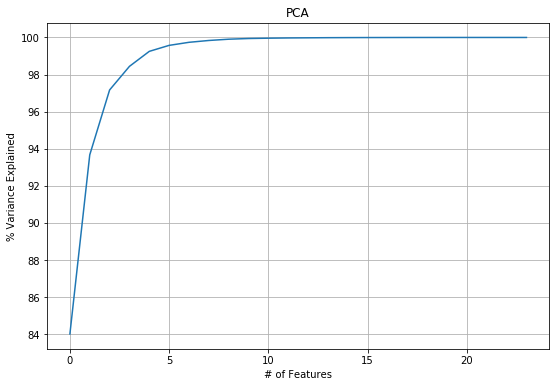

In [11]:
fig,ax=plt.subplots(1,figsize=(9,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA')
#plt.ylim(60,100.)
plt.style.context('seaborn-whitegrid')
ax.plot(np.cumsum(pcas[0].explained_variance_ratio_)*100)
plt.grid()
plt.show()

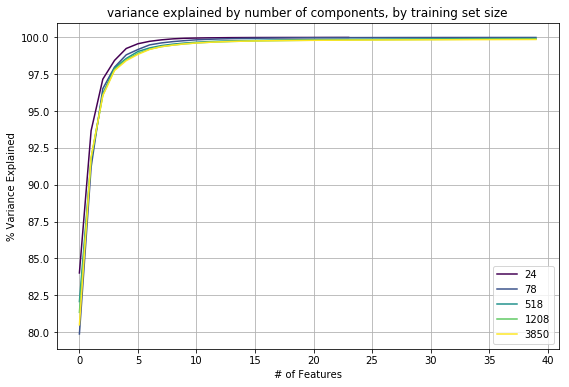

In [12]:
fig,ax=plt.subplots(1,figsize=(9,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('variance explained by number of components, by training set size')
#plt.ylim(95,100.)
plt.style.context('seaborn-whitegrid')
for i in range(len(cubes)):
    ax.plot(np.cumsum(pcas[i].explained_variance_ratio_)*100,label=str(sizes[i]),c=colors[i])
plt.legend()
plt.grid()
plt.show()

### plot all sample-mean-subtracted SEDs against the first eigen-SED

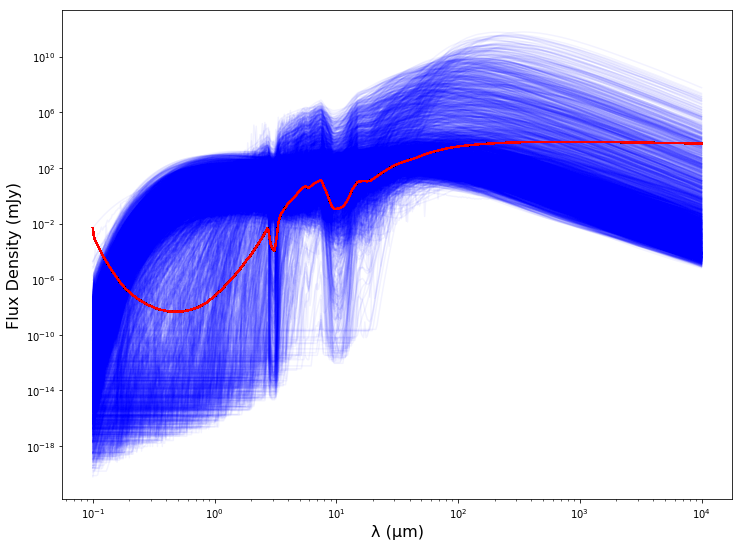

In [13]:
fig,ax=plt.subplots(1,figsize=(12,9))
for i in range(len(cubes[4])):
    fluxvals=cubes[4][i]- np.mean(cubes[4][i])
    ax.loglog(xvals, 10**fluxvals, alpha=0.05, c='b')
    ax.loglog(xvals,10**(eigenseds[4][0]*100),c='r')
#ax.set_ylim(1e-20,1e7)
plt.ylabel("Flux Density (mJy)",fontsize=16)
plt.xlabel("λ (μm)",fontsize=16)
plt.show()

### compare log-spaced SEDs reconstructed with increasing number of components against pdspy SED

In [14]:
def sedcomp(model,ds,ncomp=40, nfeat=500):
    fig,ax=plt.subplots(1,figsize=(12,9))
    coeffs=pcas[ds].transform(seds_msubs[ds][model].reshape(1,-1))
    reconst=np.dot(coeffs[0][0:ncomp+1],eigenseds[ds][0:ncomp+1,0:nfeat]) \
            +pcas[ds].mean_[0:nfeat]+np.mean(cubes[ds][model])    
    ax.plot(np.log10(xvals)[0:nfeat], reconst, c='b',label="reconstructed SED, ncomp="+str(ncomp+1))
    ax.plot(np.log10(xvals)[0:nfeat], cubes[ds][model][0:nfeat], c='black',label="pdspy SED")
    plt.legend()
    plt.title("reconstructed SED of "+str(sizes[ds])+"cube model #"+str(model)+" against pdspy SED")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

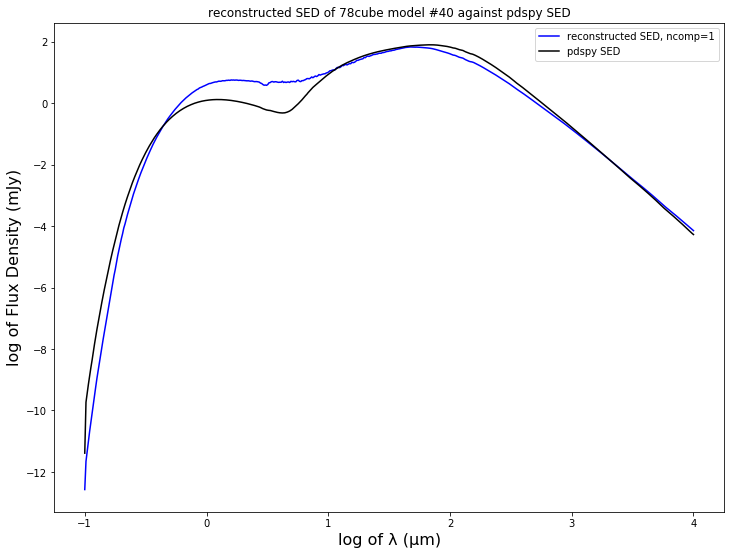

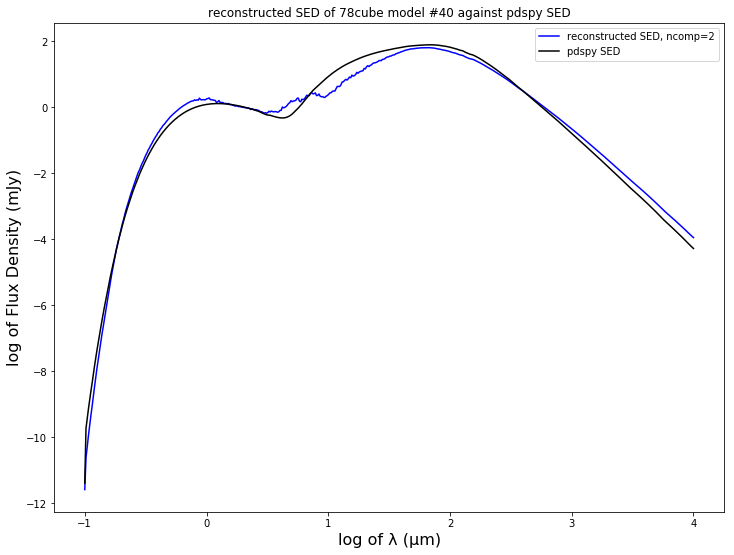

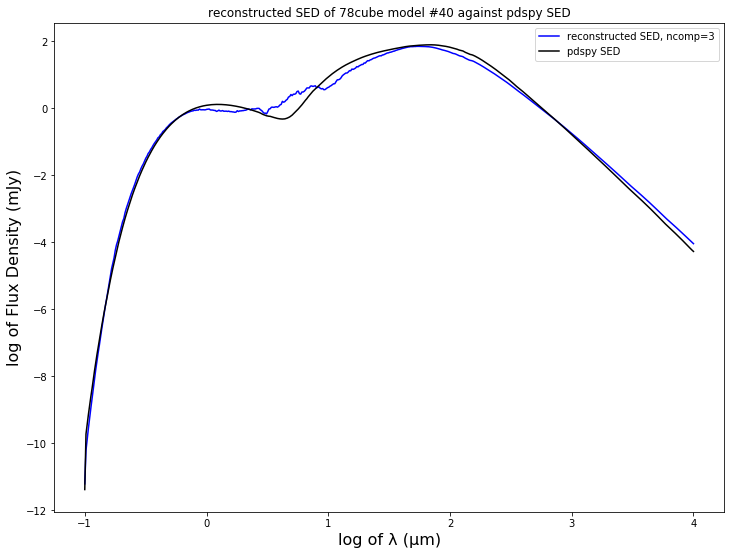

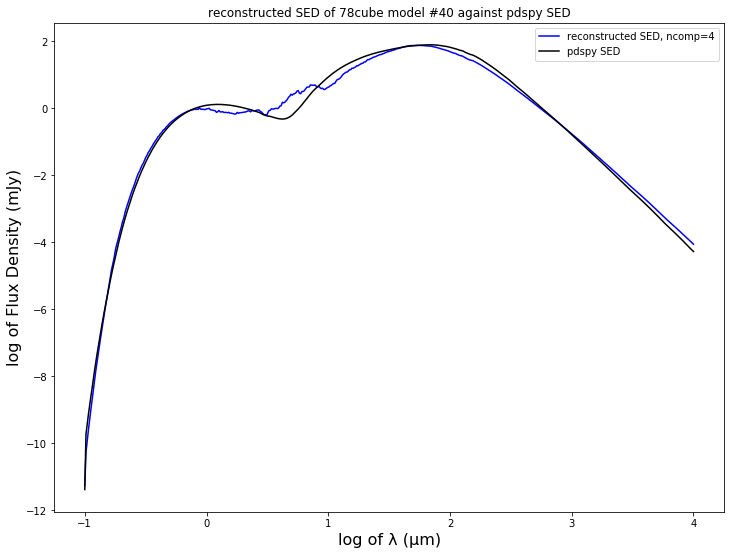

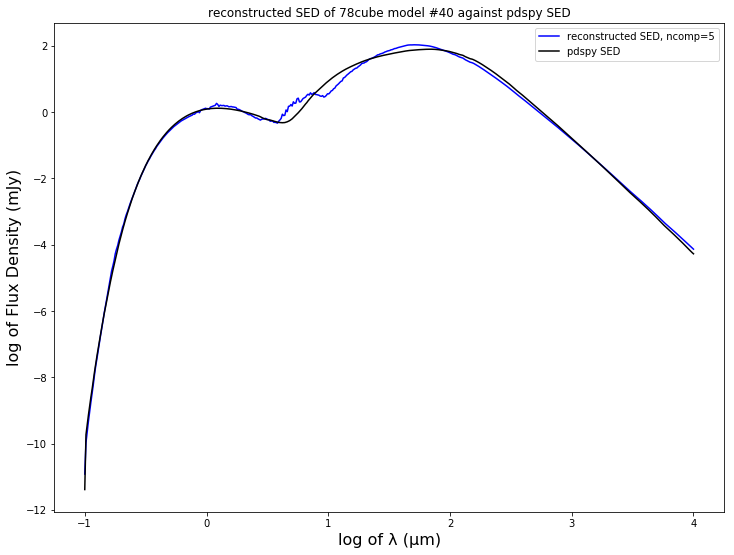

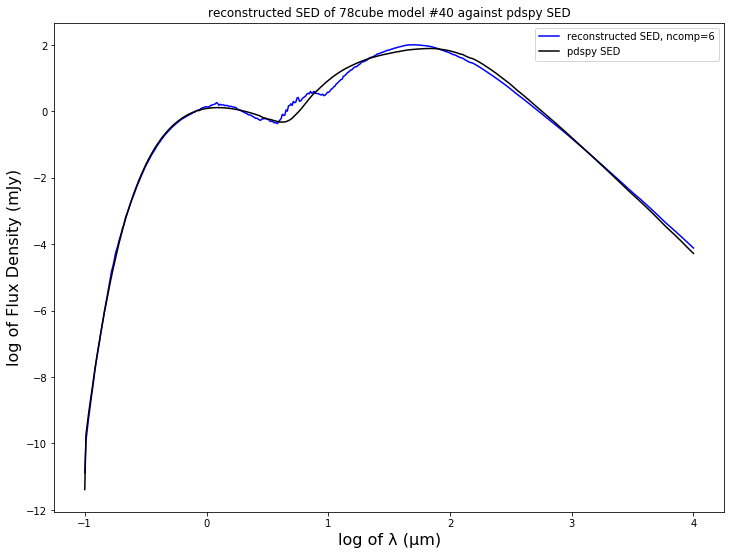

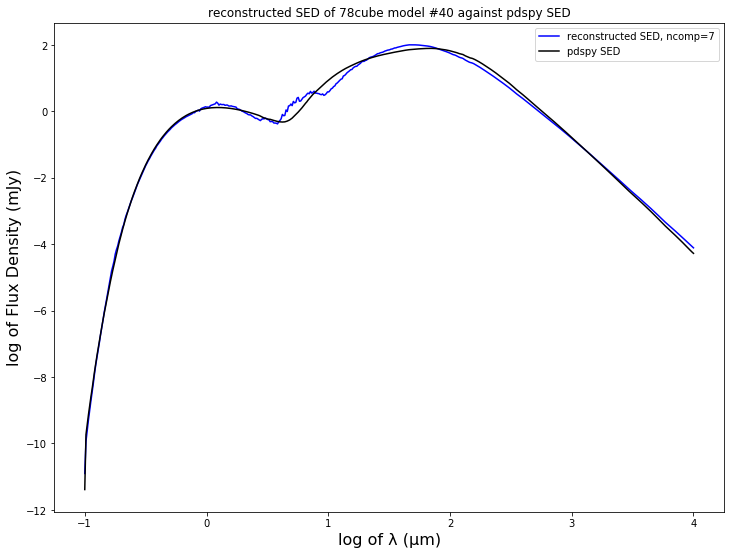

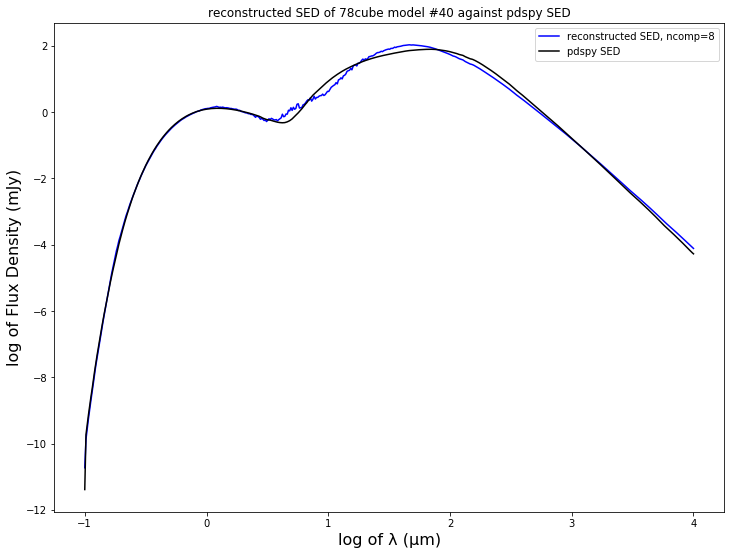

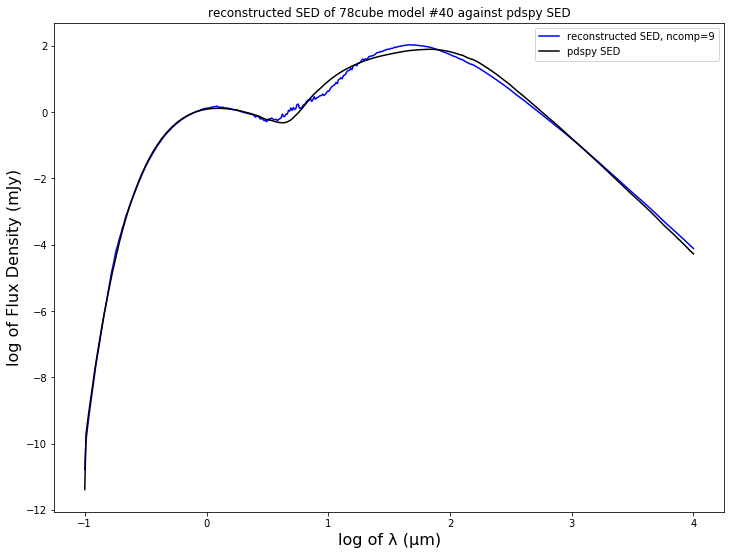

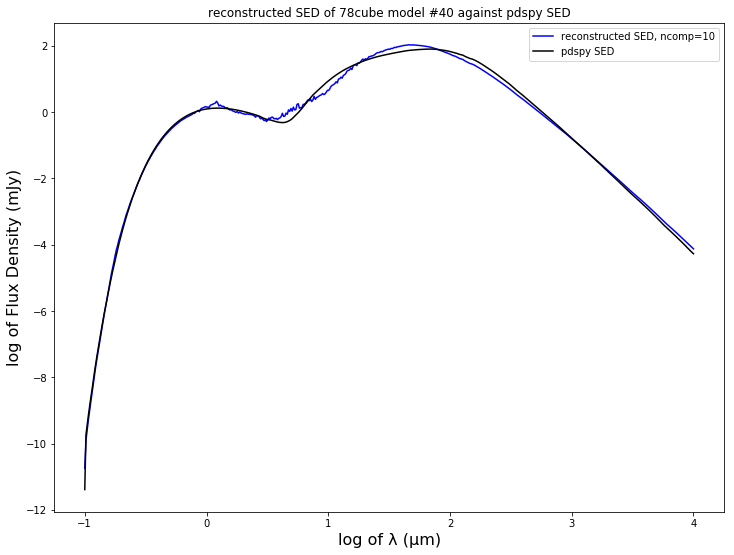

In [15]:
for m in range(10):
    sedcomp(40,1,ncomp=m)

In [16]:
def sedcomp_anim(model,ds,ncomp=40,nfeat=500):
    
    fig,ax= plt.subplots(figsize=(12,9))
    ax.plot(np.log10(xvals)[0:nfeat], cubes[ds][model][0:nfeat], c='black',label="pdspy SED")
        
    coeffs=pcas[ds].transform(seds_msubs[ds][model].reshape(1,-1)) 
    reconst=[]
    for j in range(ncomp):
        reconst.append(np.dot(coeffs[0][0:j+1],eigenseds[ds][0:j+1,0:nfeat]) +\
                       pcas[ds].mean_[0:nfeat]+np.mean(cubes[ds][model]))
    
    line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')
    
    def animate(i):
        label="number of components = {0}".format(int(i//1))
        line.set_ydata(reconst[int(i//1)])
        ax.set_xlabel("log of λ (μm)",fontsize=16)
        ax.set_ylabel("log of Flux Density (mJy)",fontsize=16)
        ax.set_title("reconstructed SED of "+str(sizes[ds])+" model #"+str(model)+" against pdspy SED, ncomp="+str(int(i//1)+1))
        return line,ax

    anim=FuncAnimation(fig,animate,frames=np.arange(0,ncomp,0.25),interval=1)
    anim.save("../visualization/comp_sets/sedcomp_"+str(sizes[ds])+"_m"+str(model)+"_nc"+str(ncomp)+".gif", dpi=72, writer="imagemagick")

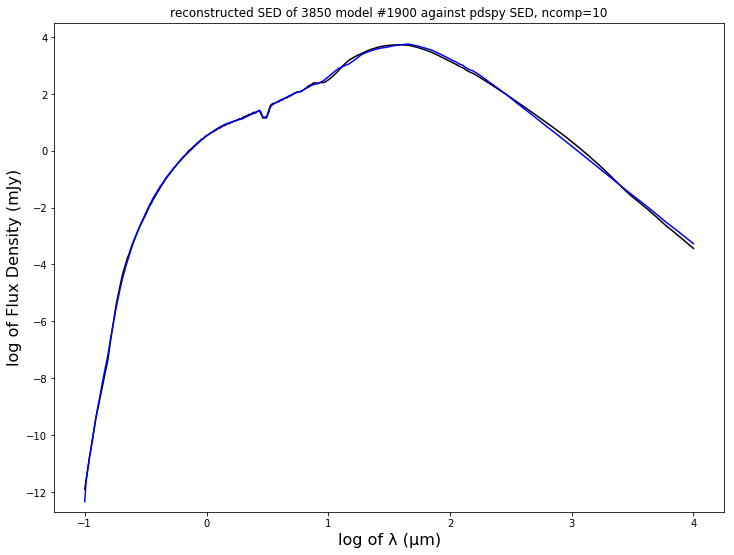

In [17]:
sedcomp_anim(1900,4,ncomp=10)

In [18]:
def findall(model,ds):
    coords=[]
    name=cores[ds][model]
    for ds in range(len(cubes)):
        if name in cores[ds]:
            coords.append([ds,cores[ds].index(name)])
    return coords
        

In [19]:
def multi_sedcomp_anim(model,ds,ncomp=40,nfeat=500):
    
    coords=findall(model,ds)
    
    for inst in range(len(coords)):
        
        ds = coords[inst][0]
        model=coords[inst][1]

        fig,ax= plt.subplots(figsize=(12,9))
        ax.plot(np.log10(xvals)[0:nfeat], cubes[ds][model][0:nfeat], c='black',label="pdspy SED")

        coeffs=pcas[ds].transform(seds_msubs[ds][model].reshape(1,-1)) 
        reconst=[]
        for j in range(ncomp):
            reconst.append(np.dot(coeffs[0][0:j+1],eigenseds[ds][0:j+1,0:nfeat]) +\
                           pcas[ds].mean_[0:nfeat]+np.mean(cubes[ds][model]))

        line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')

        def animate(i):
            label="number of components = {0}".format(int(i//1))
            line.set_ydata(reconst[int(i//1)])
            ax.set_xlabel("log of λ (μm)",fontsize=16)
            ax.set_ylabel("log of Flux Density (mJy)",fontsize=16)
            ax.set_title("reconstructed SED of "+str(sizes[ds])+" model #"+str(model)+" against pdspy SED, ncomp="+str(int(i//1)+1))
            return line,ax

        anim=FuncAnimation(fig,animate,frames=np.arange(0,ncomp,0.25),interval=1)
        anim.save("../visualization/comp_sets/mfull"+str(coords[-1][1])+"_pca"+str(sizes[ds])+"_nc"+str(ncomp)+".gif", dpi=72, writer="imagemagick")
        
        print("done with "+str(sizes[ds])+" model")
        print("mfull=",str(coords[-1][1]))

done with 24 model
mfull= 637
done with 78 model
mfull= 637
done with 518 model
mfull= 637
done with 1208 model
mfull= 637
done with 3850 model
mfull= 637


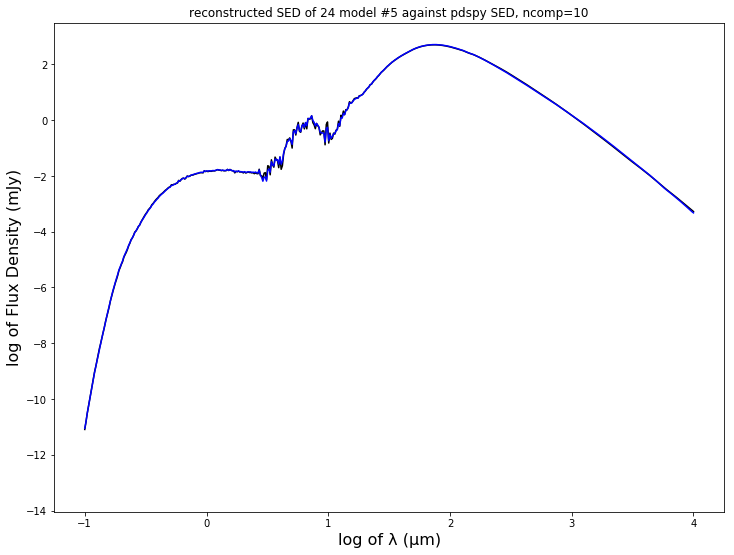

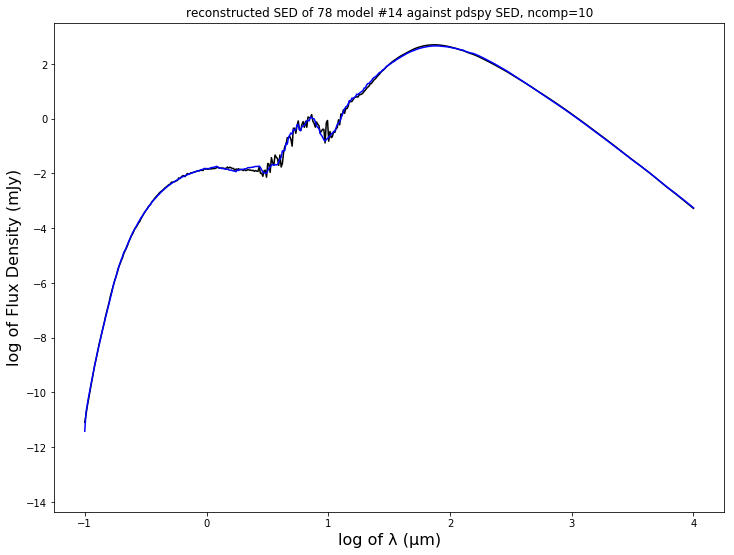

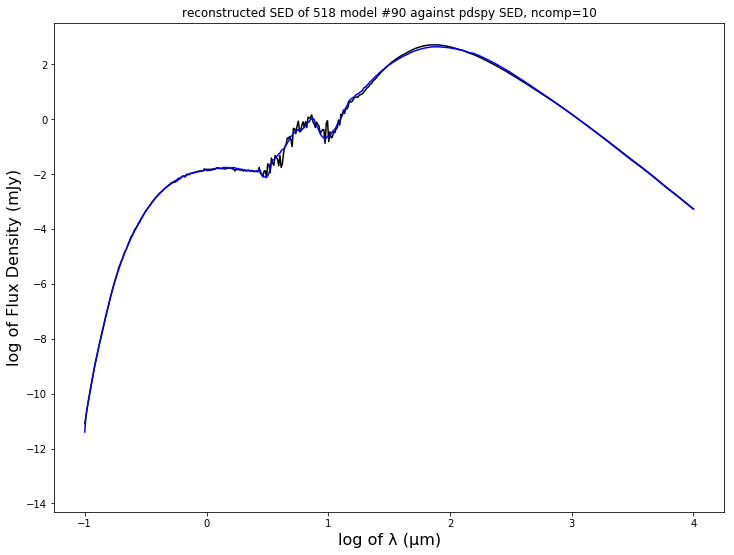

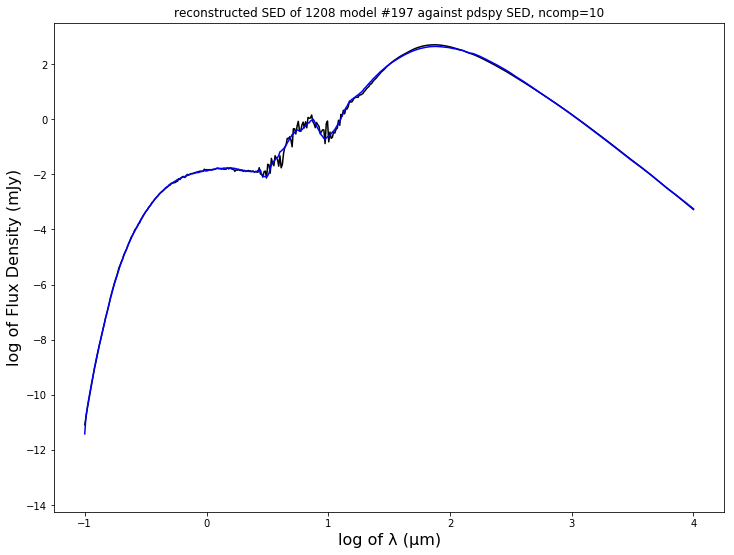

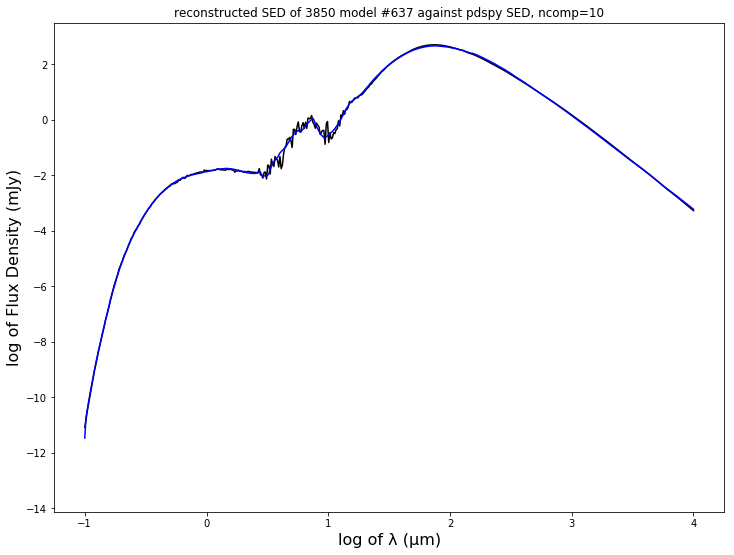

In [20]:
multi_sedcomp_anim(5,0,ncomp=10)

### compare log-spaced residuals of SEDs reconstructed with increasing number of components

In [21]:
def residcomp(model,ds,ncomp=40,nfeat=500):
    
    interval=np.linspace(0.1,1.,ncomp)
    colors= plt.cm.viridis(interval)
    
    fig,ax=plt.subplots(1,figsize=(12,9))
    
    for m in range(ncomp):
        coeffs=pcas[ds].transform(seds_msubs[ds][i].reshape(1,-1))
        reconst=np.dot(coeffs[0][0:m+1],eigenseds[ds][0:m+1,0:nfeat]) \
                +pcas[ds].mean_[0:nfeat]+np.mean(cubes[ds][model])
        resids = reconst-(cubes[ds][i][0:nfeat]) # log flux space residuals
        # resids = 10**reconst-10**(cubes[ds][i][0:nfeat]) # normal flux space residuals
        ax.plot(np.log10(xvals)[0:nfeat],resids, c=colors[m],label="ncomp="+str(m+1)) 
    plt.legend()
    plt.title("log-space residuals of reconst. SEDs of "+str(sizes[ds])+" model #"+str(i)+\
              ", by number of components")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

IndexError: index 3849 is out of bounds for axis 0 with size 1208

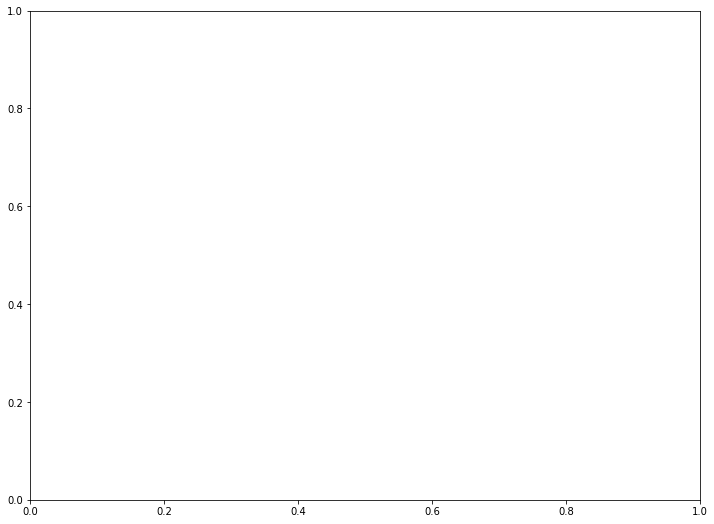

In [22]:
residcomp(100,3,ncomp=10)